In [1]:
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd
import glob
import string
import re
import pymorphy3
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio


pio.renderers.default = "notebook"  
nltk.download('punkt_tab') 
nltk.download('stopwords') 

[nltk_data] Error loading punkt_tab: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>
[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


False

In [2]:
df = pd.read_csv('PDF_dataset.csv')
df_desc = pd.read_csv('imdb_rating.csv')
df

,NameCompany,Raiting,DataPublish,Text
0,red_mad_robot,117.94,2025-03-18 10:14:48,"Средний18 мин\nredmadrobot\nCocoapods, Carthag..."
1,КАК СТАТЬ АВТОРОМ,419.00,2025-03-18 10:14:48,"Еще до начала MWC в Барселоне было очевидно, ч..."
2,Cloud4Y,71.07,2025-03-18 10:14:48,Взлом Instagram*‑аккаунта — популярный запрос ...
3,Cloud4Y,71.07,2025-03-18 10:14:48,Взлом Instagram*аккаунта — популярный запрос в...
4,КАК СТАТЬ АВТОРОМ,6.00,2025-03-18 10:14:48,Нидерландская компания Yandex N.V. по итогам р...
5,280.79,4.29,2025-03-18 10:14:48,Обеспечиваем стабильную работу highload-проект...
6,КАК СТАТЬ АВТОРОМ,107.00,2025-03-18 10:14:48,"Митчелл Бейкер, гендиректор Mozilla с 2020 год..."
7,Конкурс рассказов,466.00,2025-03-18 10:14:48,Для привлечения внимания расскажу историю. Уже...
8,КАК СТАТЬ АВТОРОМ,85.00,2025-03-18 10:14:48,"Привет! Меня зовут Денис, я занимаюсь коммерче..."
9,Альфа-Банк,404.32,2025-03-18 10:14:48,"В Альфа-Банке мы внедрили ИИ-агентов, которые ..."


### Предобработка текстовых данных

In [3]:
def remove_punctuation(text): 
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text): 
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text): 
    return re.sub(r'\s+', ' ', text, flags=re.I)

st = '❯\xa0—«»'
def remove_othersymbol(text):
    return ''.join([ch if ch not in st else ' ' for ch in text])

In [4]:
df['Text'] = [remove_multiple_spaces(remove_numbers(remove_othersymbol(remove_punctuation(str(text).lower())))) for text in df['Text']]
df_desc['Описание'] = [remove_multiple_spaces(remove_numbers(remove_othersymbol(remove_punctuation(str(text).lower())))) for text in df_desc['Описание']]

df['Text'][0]

# убрал пунктуацию и сделал lower_case для основного текста статьи


'средний мин redmadrobot cocoapods carthage spm как выбрать менеджер зависимостей в ios блог компании red mad robot разработка под ios faq как стать автором старший ios разработчик red mad robot аня кочешкова рассказывает чем отличаются три менеджера зависимостей в каких случаях и для каких задач подойдёт тот или иной материал будет полезен джун специалистам которые только начали погружаться в разработку специально для них подробно объясняем что такое семантическое версионирование как устроены модули кода и в чём разница между динамическими и статическими библиотеками что такое менеджер зависимостей и зачем он нужен в современной разработке зависимость это написанный кем то другим код который используется в вашей программе добавление зависимости позволяет воспользоваться уже сделанной кем то хорошей работой и избежать изобретения велосипеда а также лишних действий проектирования написания тестирования отладки и поддержки определённой логики такие куски логики называют пакетами библиоте

In [5]:
russian_stopwords = stopwords.words('russian') 

def tokenize(text):
    t = word_tokenize(text)
    tokens = [token for token in t if token not in russian_stopwords]
    return " ".join(tokens)

In [6]:
df['tokenize_text'] = [tokenize(text) for text in df['Text']]

df_desc['tokenize_text_desc'] = [tokenize(text) for text in df_desc['Описание']]


df['tokenize_text'].head(5)





0    средний мин redmadrobot cocoapods carthage spm...
1    начала mwc барселоне очевидно хотя оператор пр...
2    взлом instagram ‑аккаунта популярный запрос по...
3    взлом instagram аккаунта популярный запрос пои...
4    нидерландская компания yandex n v итогам рестр...
Name: tokenize_text, dtype: object

In [7]:
russian_stopwords = stopwords.words('russian') 

def remove_stopwords(text):
    text = [word for word in text if word not in russian_stopwords]
    return text

remove_stopwords(df['tokenize_text'])
remove_stopwords(df_desc['tokenize_text_desc'])

df['tokenize_text']


0     средний мин redmadrobot cocoapods carthage spm...
1     начала mwc барселоне очевидно хотя оператор пр...
2     взлом instagram ‑аккаунта популярный запрос по...
3     взлом instagram аккаунта популярный запрос пои...
4     нидерландская компания yandex n v итогам рестр...
5     обеспечиваем стабильную работу highload проект...
6     митчелл бейкер гендиректор mozilla года объяви...
7     привлечения внимания расскажу историю лет живу...
8     привет зовут денис занимаюсь коммерческим прог...
9     альфа банке внедрили ии агентов которые проект...
10    часа назад простой мин ru vds инструменты набл...
11    экосистема развития людей вовлеченных it февра...
12    look use the source указывайте количественно к...
13    образов этих дисков остаётся актуальным многие...
14    средний мин artyomsoft создать аппаратный эмул...
15    потоки vds vps хостинг скидка коду habr пишет ...
16    ruvds com vds vps хостинг скидка коду habr пиш...
17    стать автором идея почему использовать воз

In [8]:
stemmer = SnowballStemmer("russian")

stem_list = []
for text in (df['tokenize_text']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = stemmer.stem(word)
            res.append(p)
        text = " ".join(res)
        stem_list.append(text)
        
    except Exception as e:
        print(e)
        
df['text_stem'] = stem_list

df['text_stem'].head(5)

0    средн мин redmadrobot cocoapods carthage spm в...
1    нача mwc барселон очевидн хот оператор предста...
2    взлом instagram ‑аккаунт популярн запрос поиск...
3    взлом instagram аккаунт популярн запрос поиско...
4    нидерландск компан yandex n v итог реструктури...
Name: text_stem, dtype: object

In [9]:
morph = pymorphy3.MorphAnalyzer(lang='ru')

In [10]:
%%time
lemm_texts_list = []
for text in (df['tokenize_text']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = morph.parse(word)[0]
            res.append(p.normal_form)
        text = " ".join(res)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)
        

    
df['text_lemm'] = lemm_texts_list

df['text_lemm'].head(5)

CPU times: total: 2.3 s
Wall time: 2.43 s


0    средний мина redmadrobot cocoapods carthage sp...
1    начало mwc барселона очевидный хотя оператор п...
2    взлом instagram ‑аккаунт популярный запрос пои...
3    взлом instagram аккаунт популярный запрос поис...
4    нидерландский компания yandex n v итог реструк...
Name: text_lemm, dtype: object

In [11]:
stemmer = SnowballStemmer("russian")

stem_list = []
for text in (df_desc['tokenize_text_desc']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = stemmer.stem(word)
            res.append(p)
        text = " ".join(res)
        stem_list.append(text)
        
    except Exception as e:
        print(e)
        
df_desc['text_stem_desc'] = stem_list

df_desc['text_stem_desc'].head(5)

0    побе́г шоуше́нк англ the shawshank redemption ...
1                                  крестн оте́ц означа
2    темн ры́цар англ the dark knight американск по...
3    крестн оте́ц англ the godfather part ii америк...
4         разгнева мужчин англ twelve angry men означа
Name: text_stem_desc, dtype: object

In [12]:
%%time
lemm_texts_list = []
for text in (df_desc['tokenize_text_desc']):
    try:
        tokens = word_tokenize(text)
        res = list()
        for word in tokens:
            p = morph.parse(word)[0]
            res.append(p.normal_form)
        text = " ".join(res)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)
        

    
df_desc['text_lemm_desc'] = lemm_texts_list

df_desc['text_lemm_desc'].head(5)

CPU times: total: 1.33 s
Wall time: 1.38 s


0    побе́г шоуше́нка англ the shawshank redemption...
1                             крёстный оте́ца означать
2    тёмный ры́царь англ the dark knight американск...
3    крёстный оте́ца англ the godfather part ii аме...
4    разгневать мужчина англ twelve angry men означать
Name: text_lemm_desc, dtype: object

In [13]:
import re
from collections import Counter

def remove_most_common_words(text, num_words=10):
   
    words = re.findall(r"\b[a-zA-Zа-яА-ЯёЁ]+\b", text.lower())
    
    word_counts = Counter(words)
    
    most_common = [word for word, count in word_counts.most_common(num_words)]

    #print(word_counts)
    
    pattern = re.compile(r"\b(" + "|".join(map(re.escape, most_common)) + r")\b", flags=re.IGNORECASE)
    cleaned_text = pattern.sub("", text)
    
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()

    return cleaned_text


df['text_lemm_clear'] = [remove_most_common_words(text, 5) for text in df['text_lemm']]
df_desc['text_lemm_desc_clear'] = [remove_most_common_words(text, 5) for text in df_desc['text_lemm_desc']]
df['text_stem_clear'] = [remove_most_common_words(text, 5) for text in df['text_stem']]
df_desc['text_stem_desc_clear'] = [remove_most_common_words(text, 5) for text in df_desc['text_stem_desc']]


df['text_lemm_clear'].head(10)

df_desc['text_lemm_desc_clear'].head(10)

0    ́ шоуше́нка англ the shawshank redemption иску...
1                                                    ́
2    ры́царь англ the dark knight американский полн...
3    оте́ца англ the godfather part ii американский...
4                                         men означать
5    властели́н коле́ца возвраще́ние короля́ англ l...
6    ́ ́ндлера schindler s list американский эпичес...
7    кримина́льный чти́вый англ fiction бульварный ...
8    властели́н коле́ца бра́тство кольца́ англ lord...
9    ́ плохо́ть злой итал buono brutto cattivo англ...
Name: text_lemm_desc_clear, dtype: object

In [14]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline


# Получение текстовой строки из списка слов
def str_corpus(corpus):
    str_corpus = ''
    for i in corpus:
        str_corpus += ' ' + i
    str_corpus = str_corpus.strip()
    return str_corpus

# Получение списка всех слов в корпусе
def get_corpus(data):
    corpus = []
    for phrase in data:
        for word in phrase.split():
            corpus.append(word)
    return corpus

# Получение облака слов
def get_wordCloud(corpus):
    wordCloud = WordCloud(background_color='white',
                              stopwords=STOPWORDS,
                              width=3000,
                              height=2500,
                              max_words=200,
                              random_state=42
                         ).generate(str_corpus(corpus))
    return wordCloud

### Облако слов лемматизированного текста

<Axes: >

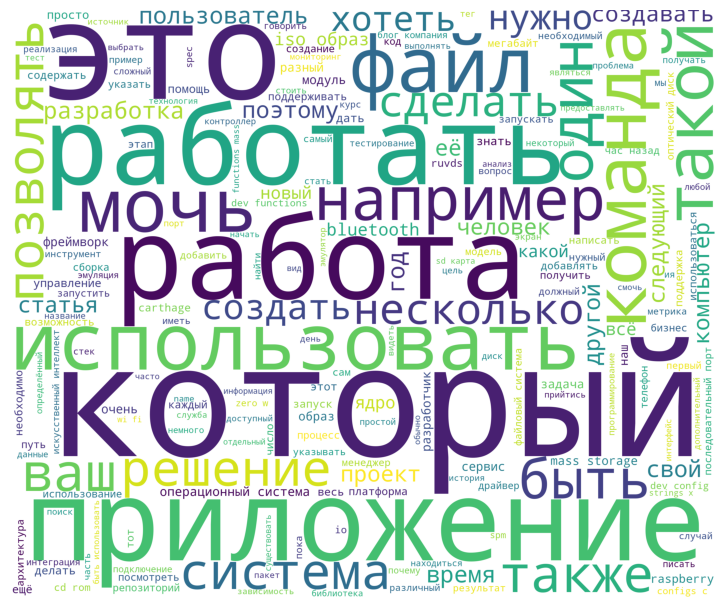

In [15]:
corpus = get_corpus(df['text_lemm_clear'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

### Облако слов стеммингованного текста

<Axes: >

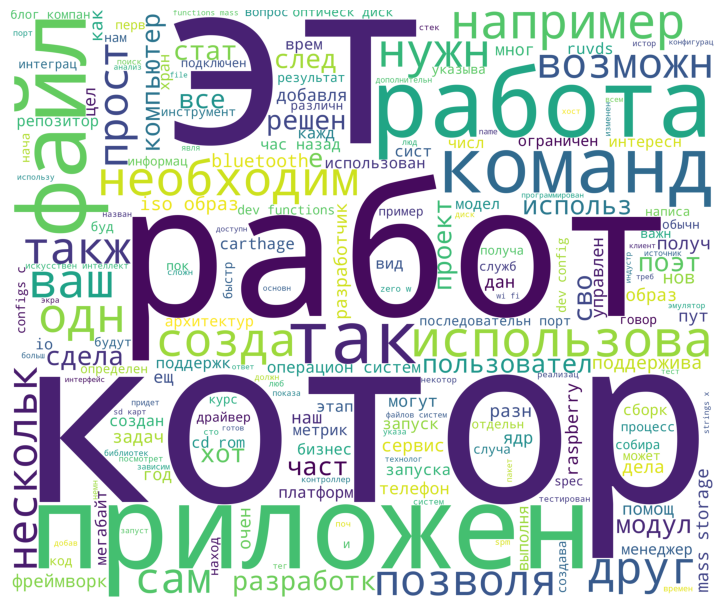

In [16]:
corpus = get_corpus(df['text_stem_clear'].values)
procWordCloud = get_wordCloud(corpus)
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

<Axes: >

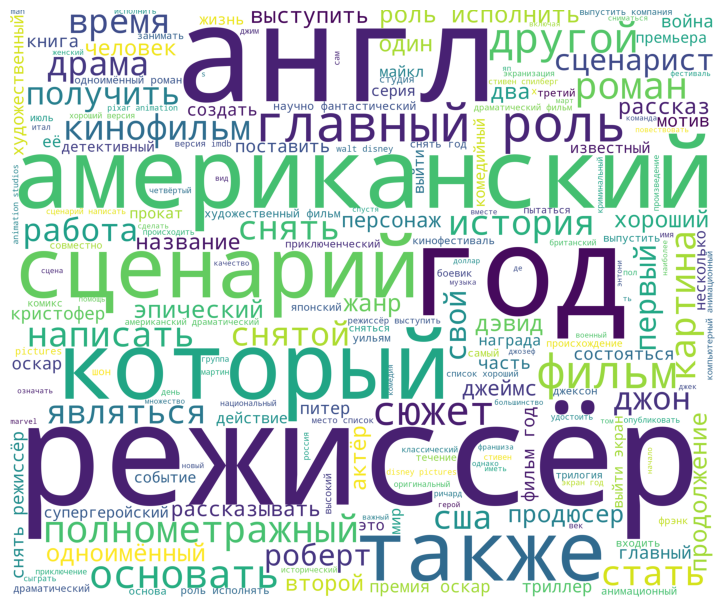

In [17]:
corpus = get_corpus(df_desc['text_lemm_desc_clear'].values)
procWordCloud = get_wordCloud(corpus)
fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

<Axes: >

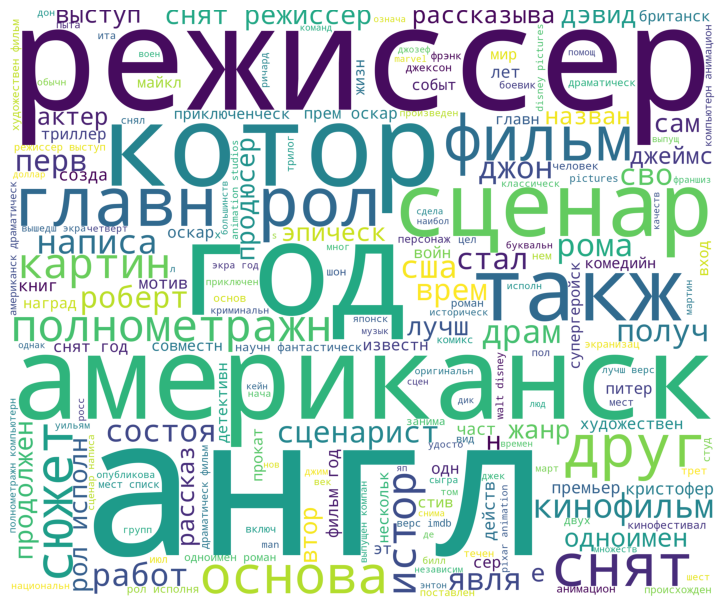

In [18]:
corpus = get_corpus(df_desc['text_stem_desc_clear'].values)
procWordCloud = get_wordCloud(corpus)

fig = plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(procWordCloud)
plt.axis('off')
plt.subplot(1, 2, 1)

# Тематическое моделирование

In [19]:
def tokenize2(text):
    if isinstance(text, list):  
        return text  
    if not isinstance(text, str):  
        return []  
    
    tokens = word_tokenize(text.lower(), language='russian')
    tokens = [token for token in tokens 
              if token not in russian_stopwords and len(token) >= 2]
    return tokens  

In [20]:
import gensim

df_desc['text_lemm_desc_clear_tokenize'] = [tokenize2(text) for text in df_desc['text_lemm_desc_clear']]
df_desc['text_stem_desc_clear_tokenize'] = [tokenize2(text) for text in df_desc['text_stem_desc_clear']]

df['text_stem_clear_tokenize'] = [tokenize2(text) for text in df['text_stem_clear']]
df['text_lemm_clear_tokenize'] = [tokenize2(text) for text in df['text_lemm_clear']]
        


gensim_dictionary = gensim.corpora.Dictionary(df_desc['text_lemm_desc_clear_tokenize'])
gensim_dictionary.filter_extremes(no_above=0.5, no_below=5)
gensim_dictionary.compactify()


gensim_dictionary1 = gensim.corpora.Dictionary(df['text_lemm_clear_tokenize'])
gensim_dictionary1.filter_extremes(no_above=0.5, no_below=5)
gensim_dictionary1.compactify()

gensim_dictionary2 = gensim.corpora.Dictionary(df['text_stem_clear_tokenize'])
gensim_dictionary2.filter_extremes(no_above=0.5, no_below=5)
gensim_dictionary2.compactify()


corpus = [gensim_dictionary.doc2bow(text) 
          for text in df_desc['text_lemm_desc_clear_tokenize']]

corpus1 = [gensim_dictionary.doc2bow(text) 
          for text in df_desc['text_stem_desc_clear_tokenize']]

corpus2 = [gensim_dictionary1.doc2bow(text) 
          for text in df['text_lemm_clear_tokenize']]

corpus3 = [gensim_dictionary2.doc2bow(text) 
          for text in df['text_stem_clear_tokenize']]



In [21]:
lda_20 = gensim.models.LdaMulticore(corpus, 
                                 num_topics=10, 
                                 id2word=gensim_dictionary, 
                                 passes=10, random_state=6457)

lda_20.print_topics()

[(0,
  '0.045*"англ" + 0.044*"год" + 0.043*"снять" + 0.041*"режиссёр" + 0.035*"драматический" + 0.035*"джон" + 0.035*"фильм" + 0.034*"американский" + 0.029*"роман" + 0.027*"the"'),
 (1,
  '0.039*"хороший" + 0.034*"англ" + 0.033*"режиссёр" + 0.031*"of" + 0.031*"оскар" + 0.031*"год" + 0.029*"категория" + 0.029*"работа" + 0.024*"премия" + 0.023*"также"'),
 (2,
  '0.032*"полнометражный" + 0.029*"супергеройский" + 0.028*"вселенная" + 0.026*"режиссёр" + 0.025*"американский" + 0.024*"сюжет" + 0.023*"основать" + 0.022*"англ" + 0.021*"также" + 0.020*"создать"'),
 (3,
  '0.036*"режиссёр" + 0.035*"фильм" + 0.024*"год" + 0.022*"который" + 0.021*"история" + 0.021*"драма" + 0.021*"место" + 0.021*"кино" + 0.021*"хороший" + 0.021*"жанр"'),
 (4,
  '0.042*"англ" + 0.038*"также" + 0.026*"человек" + 0.025*"хороший" + 0.025*"the" + 0.021*"иметь" + 0.019*"который" + 0.018*"экранизация" + 0.017*"её" + 0.017*"несколько"'),
 (5,
  '0.056*"состояться" + 0.054*"премьера" + 0.033*"режиссёр" + 0.031*"полнометражны

In [22]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis


In [23]:
vis_20 = gensimvis.prepare(lda_20, corpus, gensim_dictionary)

pyLDAvis.enable_notebook()

# LDA для habr статей

In [24]:
vis_20

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9     -0.139805 -0.087466       1        1  14.299048
6     -0.053854  0.015688       2        1  14.100660
7     -0.008052  0.106089       3        1  12.868075
3      0.103853  0.055419       4        1  10.932618
0     -0.084972  0.115201       5        1   9.902955
1      0.095654  0.000759       6        1   9.177961
2     -0.142327 -0.058890       7        1   8.627687
4      0.122453 -0.012985       8        1   7.570752
5      0.087972 -0.156862       9        1   7.293465
8      0.019076  0.023047      10        1   5.226779, topic_info=              Term       Freq      Total Category  logprob  loglift
131     состояться  14.000000  14.000000  Default  30.0000  30.0000
128       премьера  13.000000  13.000000  Default  29.0000  29.0000
125        хороший  29.000000  29.000000  Default  28.0000  28.0000
6    драматический  20.000000  20.000000  Default  27.0000  27.0000
9          который  46.000000  46.000000  Default  26.0000  26.0000
..             ...        ...        ...      ...      ...      ...
15          стивен   1.366149  12.081539  Topic10  -4.6369   0.7717
19           фильм   2.338163  55.146823  Topic10  -4.0995  -0.2093
13        режиссёр   2.666895  90.916375  Topic10  -3.9680  -0.5777
97            роль   1.863174  44.174461  Topic10  -4.3266  -0.2145
92         главный   1.863261  46.149261  Topic10  -4.3266  -0.2582

[469 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
89        2  0.241572        and
89        3  0.241572        and
89        5  0.241572        and
89        8  0.120786        and
168       1  0.882933  animation
...     ...       ...        ...
156       6  0.179302         яп
156       9  0.358604         яп
137       2  0.246494   японский
137       6  0.123247   японский
137      10  0.492988   японский

[900 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 8, 4, 1, 2, 3, 5, 6, 9])

In [25]:
lda_21 = gensim.models.LdaMulticore(corpus2, 
    num_topics=10, 
    id2word=gensim_dictionary1, 
    passes=10, random_state=6457)


vis_21 = gensimvis.prepare(lda_21, corpus2, gensim_dictionary1)

pyLDAvis.enable_notebook()

# LDA для описания фильмов

In [26]:
vis_21

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.156900  0.029899       1        1  35.030373
2      0.141982  0.048079       2        1  17.719067
4     -0.042682  0.104762       3        1  16.901954
9      0.071879 -0.172228       4        1  12.421807
0     -0.124329  0.124898       5        1  10.656296
3     -0.071952 -0.058837       6        1   4.414297
5     -0.143477 -0.114859       7        1   2.750137
7      0.005479  0.012646       8        1   0.035357
6      0.004065  0.012939       9        1   0.035357
8      0.002135  0.012701      10        1   0.035357, topic_info=            Term        Freq       Total Category  logprob  loglift
86         образ   72.000000   72.000000  Default  30.0000  30.0000
195         файл  106.000000  106.000000  Default  29.0000  29.0000
329       служба   36.000000   36.000000  Default  28.0000  28.0000
134   приложение   92.000000   92.000000  Default  27.0000  27.0000
295       сервис   40.000000   40.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
151  разработчик    0.005695   32.349922  Topic10  -5.8423  -0.6974
126      поэтому    0.005704   40.078537  Topic10  -5.8407  -0.9100
178       стоить    0.005670   25.091226  Topic10  -5.8466  -0.4476
204         этап    0.005667   25.985235  Topic10  -5.8472  -0.4832
109    платформа    0.005667   33.925406  Topic10  -5.8472  -0.7499

[569 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
336       1  0.110110       api
336       4  0.073407       api
336       5  0.807473       api
0         1  0.188265      data
0         2  0.031378      data
...     ...       ...       ...
204       7  0.038483      этап
205       1  0.436253  являться
205       2  0.145418  являться
205       5  0.290836  являться
205       6  0.096945  являться

[943 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 5, 10, 1, 4, 6, 8, 7, 9])

# Оценка CoherenceModel

In [27]:
from gensim.models import CoherenceModel

coherence_model = CoherenceModel(model=lda_20,
    texts=df_desc['text_lemm_desc_clear_tokenize'],
    dictionary=gensim_dictionary,
    coherence="c_v")

coherence_model_habr = CoherenceModel(model=lda_20,
    texts=df['text_lemm_clear_tokenize'],
    dictionary=gensim_dictionary1,
    coherence="c_v")

coherence_value = coherence_model.get_coherence()
coherence_value_habr = coherence_model_habr.get_coherence()

print(f"Когерентность модели фильмов: {coherence_value}")
print(f"Когерентность модели статей: {coherence_value_habr}")


classifiers =["Когерентность модели фильмов", "Когерентность модели статей"]
log1 = pd.DataFrame()

log1["Модель"] = classifiers
log1["сoherence score"] = [coherence_value, coherence_value_habr]


Когерентность модели фильмов: 0.60816869987031
Когерентность модели статей: 0.4190467204153226


In [28]:
log1

,Модель,сoherence score
0,Когерентность модели фильмов,0.608169
1,Когерентность модели статей,0.419047


# Векторизация 

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
vectorizer.fit(df['text_lemm'])

print(vectorizer.vocabulary_)


{'средний': 3759, 'мина': 2162, 'redmadrobot': 614, 'cocoapods': 136, 'carthage': 109, 'spm': 701, 'выбрать': 1247, 'менеджер': 2128, 'зависимость': 1570, 'ios': 367, 'блог': 1019, 'компания': 1916, 'red': 612, 'mad': 450, 'robot': 641, 'разработка': 3343, 'faq': 268, 'стать': 3788, 'автор': 887, 'старший': 3782, 'разработчик': 3344, 'аня': 951, 'кочешкова': 1987, 'рассказывать': 3383, 'отличаться': 2638, 'какой': 1844, 'случай': 3613, 'задача': 1587, 'подойти': 2856, 'иной': 1770, 'материал': 2110, 'полезный': 2916, 'джуна': 1443, 'специалист': 3728, 'который': 1985, 'начать': 2311, 'погружаться': 2827, 'специально': 3729, 'подробно': 2862, 'объяснять': 2479, 'такой': 3866, 'семантический': 3536, 'версионирование': 1104, 'устроить': 4089, 'модуль': 2203, 'код': 1891, 'что': 4246, 'разница': 3330, 'динамический': 1450, 'статический': 3785, 'библиотека': 1003, 'нужный': 2412, 'современный': 3657, 'это': 4307, 'написать': 2280, 'кто': 2011, 'другой': 1522, 'использоваться': 1810, 'ваш': 

In [30]:
vectorizer.get_feature_names_out()[10:20]

array(['add', 'adriver', 'af', 'afnetworking', 'agent', 'agetty', 'agile',
       'agima', 'ai', 'airbnb'], dtype=object)

In [31]:
from gensim.utils import simple_preprocess

def text_to_vector(text, model):
    words = simple_preprocess(text)
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(word_vectors, axis=0)

In [32]:
vectorizer = CountVectorizer(analyzer='word', stop_words=russian_stopwords, ngram_range=(1, 3), min_df=2)

df_desc['text_lemm_desc_clear_str'] = df_desc['text_lemm_desc_clear_tokenize'].apply(' '.join)
df['text_lemm_clear_str'] = df['text_lemm_clear_tokenize'].apply(' '.join)
df_desc['text_stem_desc_clear_str'] = df_desc['text_stem_desc_clear_tokenize'].apply(' '.join)
df['text_stem_clear_str'] = df['text_stem_clear_tokenize'].apply(' '.join)

count_matrix_lemm = vectorizer.fit_transform(df['text_lemm_clear_str'])
count_matrix_stem = vectorizer.fit_transform(df['text_stem_clear_str'])

count_matrix_lemm_desc = vectorizer.fit_transform(df_desc['text_lemm_desc_clear_str'])
count_matrix_stem_desc = vectorizer.fit_transform(df_desc['text_stem_desc_clear_str'])


count_matrix_lemm.shape

(20, 7685)

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000,
    min_df=0.01, stop_words=russian_stopwords,
    ngram_range=(1,3))



tfidf_matrix_lemm = tfidf_vectorizer.fit_transform(df['text_lemm_clear_str'])
tfidf_matrix_stem = tfidf_vectorizer.fit_transform(df['text_stem_clear_str'])

tfidf_matrix_lemm_desc = tfidf_vectorizer.fit_transform(df_desc['text_lemm_desc_clear_str'])
tfidf_matrix_stem_desc = tfidf_vectorizer.fit_transform(df_desc['text_stem_desc_clear_str'])

In [34]:
from gensim.models import KeyedVectors
from gensim.models import Word2Vec
import numpy as np


In [35]:
w2v_model_lemm = Word2Vec(sentences=[text.split() for text in df['text_lemm_clear_str']],
                    vector_size=300, window=5, min_count=10, workers=4)

w2v_model_stem = Word2Vec(sentences=[text.split() for text in df['text_stem_clear_str']],
                    vector_size=300, window=5, min_count=10, workers=4)


w2v_model_lemm_desc = Word2Vec(sentences=[text.split() for text in df_desc['text_lemm_desc_clear_str']],
                    vector_size=300, window=5, min_count=10, workers=4)

w2v_model_stem_desc = Word2Vec(sentences=[text.split() for text in df_desc['text_stem_desc_clear_str']],
                    vector_size=300, window=5, min_count=10, workers=4)


w2v_matrix_lemm = np.array([text_to_vector(text, w2v_model_lemm) for text in df['text_lemm_clear_str']])
w2v_matrix_stem = np.array([text_to_vector(text, w2v_model_stem) for text in df['text_stem_clear_str']])

w2v_matrix_lemm_desc = np.array([text_to_vector(text, w2v_model_lemm) for text in df_desc['text_lemm_desc_clear_str']])
w2v_matrix_stem_desc = np.array([text_to_vector(text, w2v_model_stem) for text in df_desc['text_stem_desc_clear_str']])

tfidf_matrix_stem.shape

(20, 10000)

In [36]:
print("TF-IDF samples:", tfidf_matrix_lemm.shape[0])
print("Word2Vec samples:", w2v_matrix_lemm.shape[0])

TF-IDF samples: 20
Word2Vec samples: 20


## 2d визуализация кластеров 

In [37]:
from sklearn.manifold import TSNE
def plot_tsne_optimized(X, title, texts, perplexity=None, text_length=20):
    """
    Визуализация t-SNE с автоматической настройкой для малых датасетов
    
    Параметры:
        X - матрица признаков (TF-IDF или Word2Vec)
        title - заголовок графика
        texts - список текстов для аннотаций
        perplexity - ручная установка (None для авто)
    """
    n_samples = X.shape[0]
    
    if perplexity is None:
        perplexity = min(5, n_samples - 1)  
    
    if hasattr(X, 'toarray'):
        X = X.toarray()
    
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        random_state=42,
        learning_rate=50, 
        init='pca'  
    )
    
    X_2d = tsne.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], alpha=0.7)
    
    for i, (x, y) in enumerate(X_2d):
        plt.annotate(
            str(texts[i])[:text_length] + ("..." if len(str(texts[i])) > text_length else ""), 
            (x, y),
            fontsize=8,
            alpha=0.8,
            xytext=(10, 10),
            textcoords='offset points'
        )
    
    plt.title(f"{title}\nperplexity={perplexity}, n_samples={n_samples}")
    plt.grid(True, alpha=0.2)
    plt.show()


In [38]:
def tokenize_desc(text):
    t = word_tokenize(text)
    tokens = [token for token in t if token not in russian_stopwords]
    return tokens

df_desc['Описание'] = [tokenize_desc(text) for text in df_desc['Описание']]

# Размещение кластеров статей habr на 2д плоскости

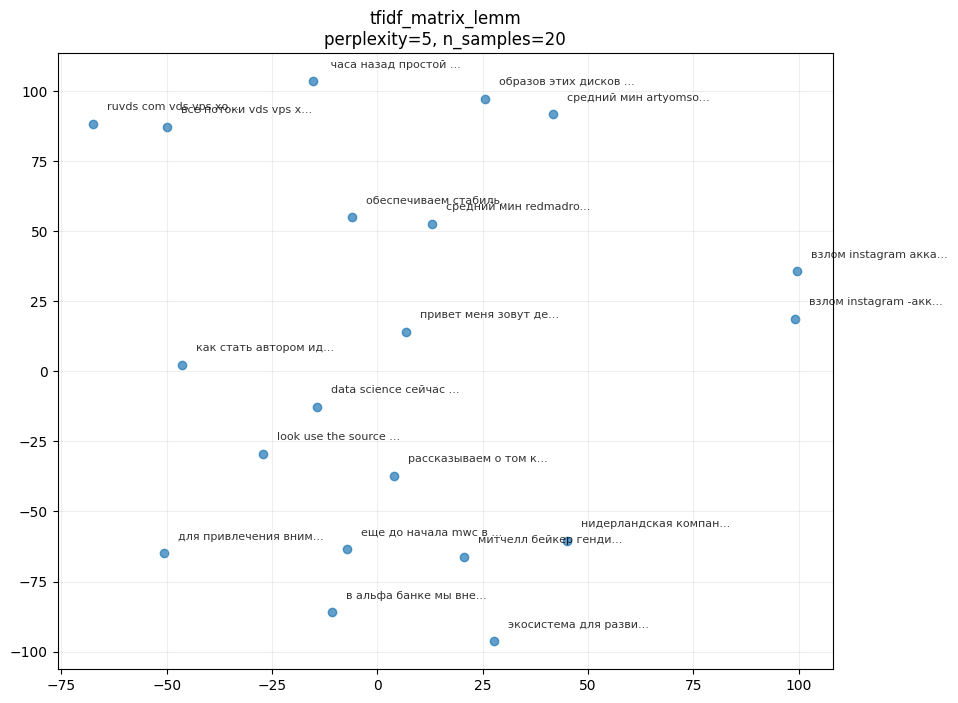

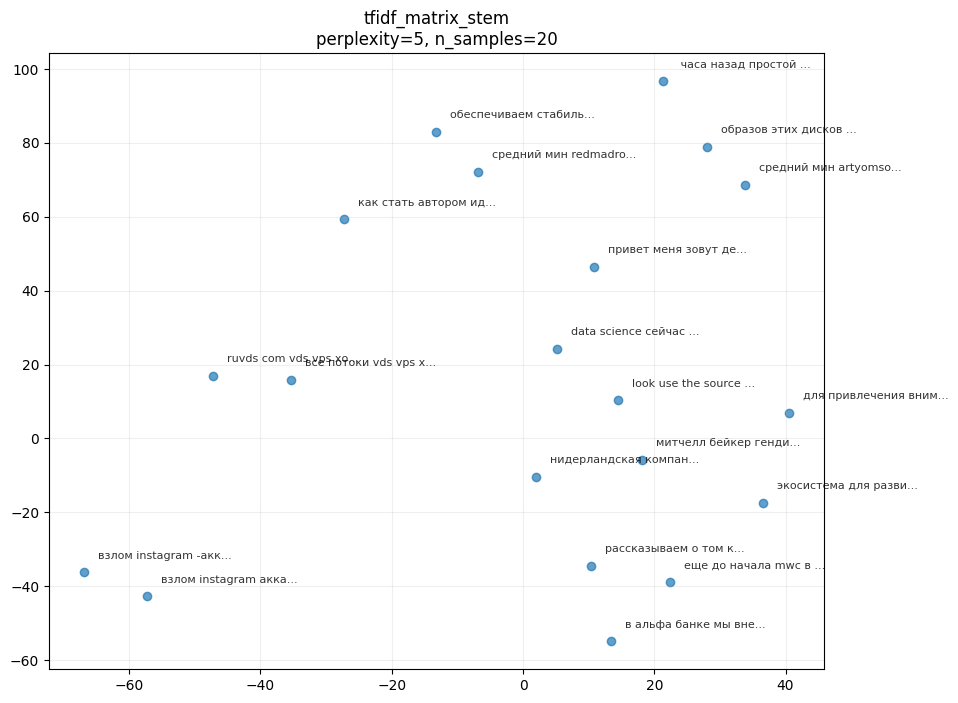

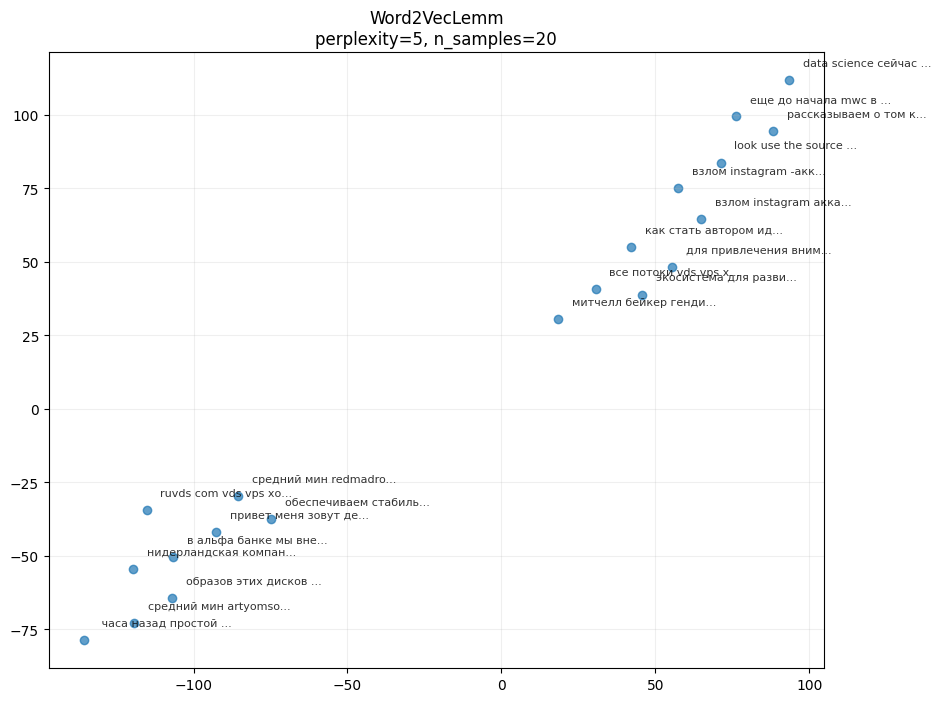

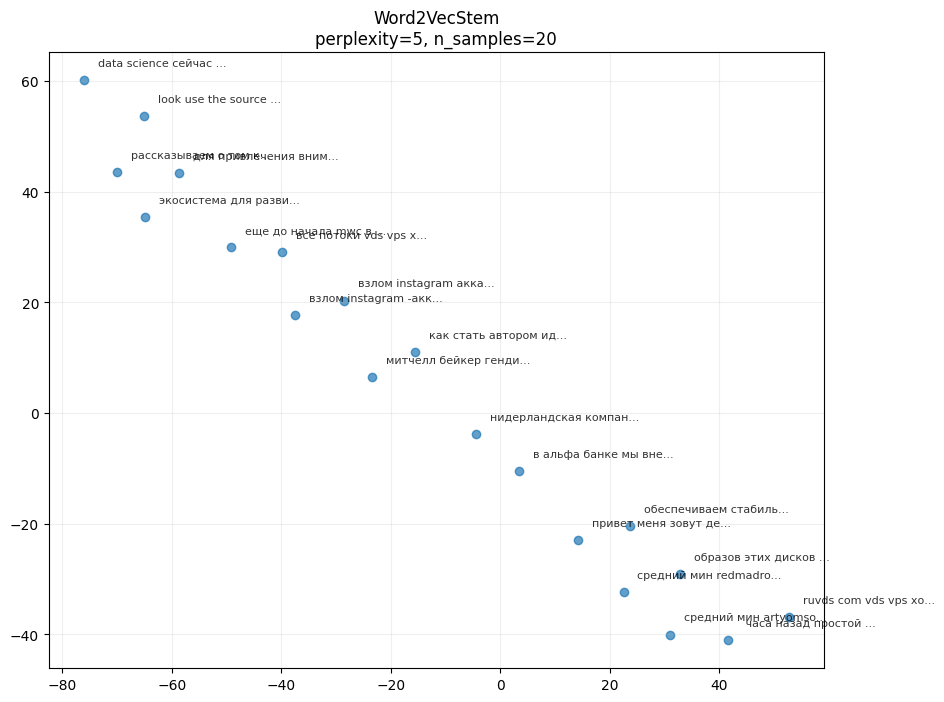

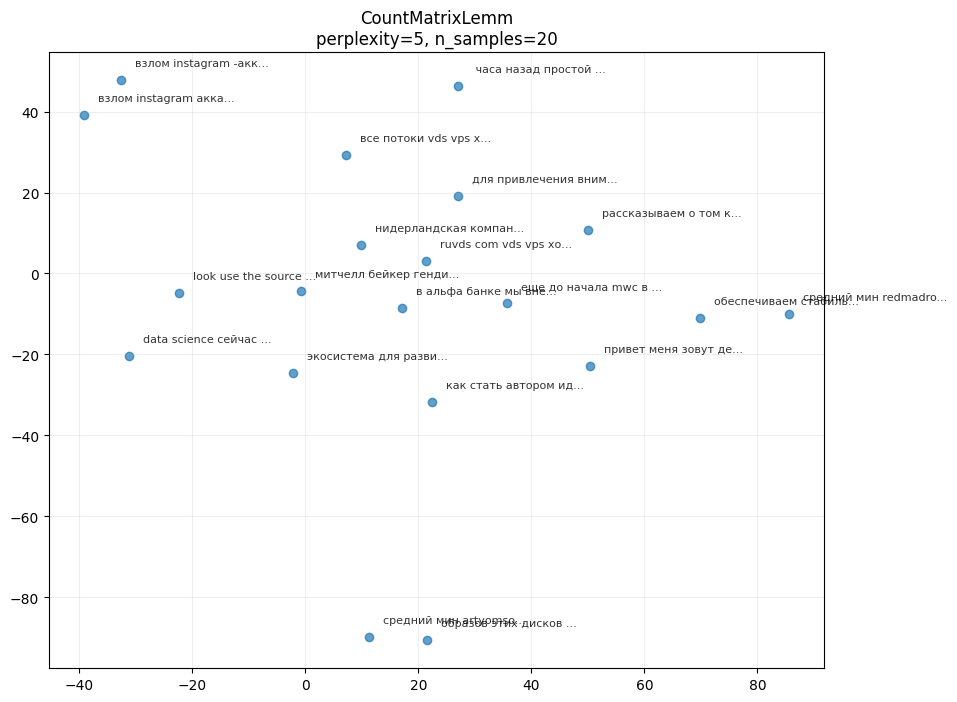

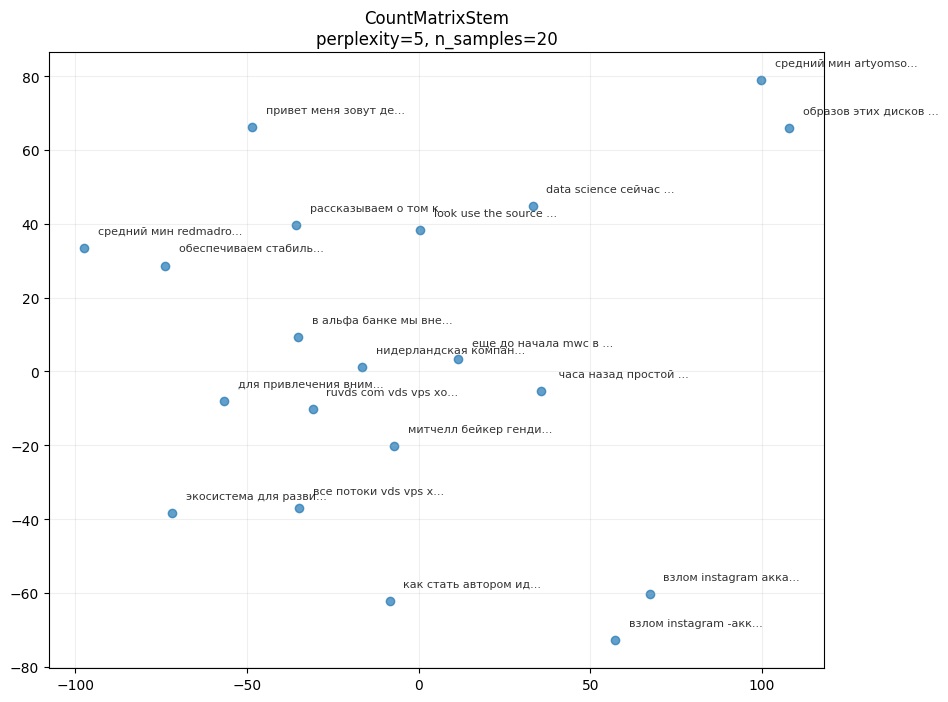

In [39]:
plot_tsne_optimized(tfidf_matrix_lemm, "tfidf_matrix_lemm", texts=df['Text'].tolist())
plot_tsne_optimized(tfidf_matrix_stem, "tfidf_matrix_stem",texts=df['Text'].tolist())
plot_tsne_optimized(w2v_matrix_lemm, "Word2VecLemm",texts=df['Text'].tolist())
plot_tsne_optimized(w2v_matrix_stem, "Word2VecStem",texts=df['Text'].tolist())
plot_tsne_optimized(count_matrix_lemm, 'CountMatrixLemm', texts=df['Text'].tolist())
plot_tsne_optimized(count_matrix_stem, 'CountMatrixStem', texts=df['Text'].tolist())

## Кластеризация Kmeans на основе векторов tfid, countMatrix, word2vec

In [40]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=5, random_state=42)

tfid_labels_lemm = kmeans.fit_predict(tfidf_matrix_lemm)  
tfid_labels_stem = kmeans.fit_predict(tfidf_matrix_stem) 

silhouette_tfid_lemm = silhouette_score(tfidf_matrix_lemm, tfid_labels_lemm)
silhouette_tfid_stem = silhouette_score(tfidf_matrix_stem, tfid_labels_stem)

In [41]:
word2vec_labels_lemm = kmeans.fit_predict(w2v_matrix_lemm)  
word2vec_labels_stem = kmeans.fit_predict(w2v_matrix_stem) 

silhouette_word2vec_lemm = silhouette_score(w2v_matrix_lemm, word2vec_labels_lemm)
silhouette_word2vec_stem = silhouette_score(w2v_matrix_stem, word2vec_labels_stem)

# Метрики для статей Habr

In [42]:
count_matrix_lemm_lables = kmeans.fit_predict(count_matrix_lemm)  
count_matrix_stem_lables = kmeans.fit_predict(count_matrix_stem) 

silhouette_count_matrix_lemm = silhouette_score(count_matrix_lemm, count_matrix_lemm_lables)
silhouette_count_matrix_stem = silhouette_score(count_matrix_stem, count_matrix_stem_lables)

In [43]:
import seaborn as sns
classifiers =["word2vec lemm", "word2vec stem", "count_matrix_lemm", "count_matrix_stem", "tfid_lemm", "tfid_stem"]
log_cols = ["Classifier","Silhoette score"]
log = pd.DataFrame(columns=log_cols)

log["Classifier"] = classifiers
log["Silhoette score"] = [silhouette_word2vec_lemm, silhouette_word2vec_stem, silhouette_count_matrix_lemm, silhouette_count_matrix_stem, silhouette_tfid_lemm, silhouette_tfid_stem]

In [44]:
log

,Classifier,Silhoette score
0,word2vec lemm,0.578338
1,word2vec stem,0.484606
2,count_matrix_lemm,0.313604
3,count_matrix_stem,0.296831
4,tfid_lemm,0.124819
5,tfid_stem,0.116582


<Axes: title={'center': 'Vector'}, xlabel='Silhoette score', ylabel='Classifier'>

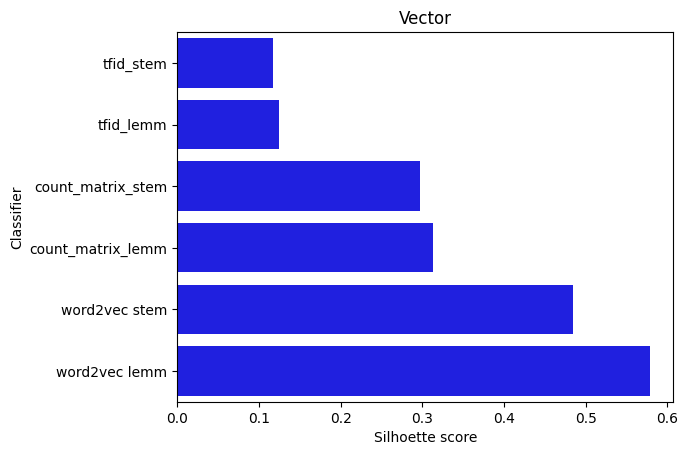

In [45]:

plt.xlabel('Silhoette score')
plt.title('Vector')

sns.barplot(x='Silhoette score', y='Classifier', data=log.sort_values(by='Silhoette score'), color="b")

In [46]:
kmeans_desc = KMeans(n_clusters=5, random_state=42)

tfid_labels_lemm_desc = kmeans_desc.fit_predict(tfidf_matrix_lemm_desc)  
tfid_labels_stem_desc = kmeans_desc.fit_predict(tfidf_matrix_stem_desc) 

silhouette_tfid_lemm_desc = silhouette_score(tfidf_matrix_lemm_desc, tfid_labels_lemm_desc)
silhouette_tfid_stem_desc = silhouette_score(tfidf_matrix_stem_desc, tfid_labels_stem_desc)

count_matrix_lemm_lables_desc = kmeans_desc.fit_predict(count_matrix_lemm_desc)  
count_matrix_stem_lables_desc = kmeans_desc.fit_predict(count_matrix_stem_desc) 

silhouette_count_matrix_lemm_desc = silhouette_score(count_matrix_lemm_desc, count_matrix_lemm_lables_desc)
silhouette_count_matrix_stem_desc = silhouette_score(count_matrix_stem_desc, count_matrix_stem_lables_desc)

word2vec_labels_lemm_desc = kmeans_desc.fit_predict(w2v_matrix_lemm_desc)  
word2vec_labels_stem_desc = kmeans_desc.fit_predict(w2v_matrix_stem_desc) 

silhouette_word2vec_lemm_desc  = silhouette_score(w2v_matrix_lemm_desc, word2vec_labels_lemm_desc)
silhouette_word2vec_stem_desc  = silhouette_score(w2v_matrix_stem_desc, word2vec_labels_stem_desc)



classifiers =["word2vec lemm", "word2vec stem", "count_matrix_lemm", "count_matrix_stem", "tfid_lemm", "tfid_stem"]
log_cols = ["Classifier","Silhoette score"]
log = pd.DataFrame(columns=log_cols)

log["Classifier"] = classifiers
log["Silhoette score"] = [silhouette_word2vec_lemm_desc, silhouette_word2vec_stem_desc, silhouette_count_matrix_lemm_desc, silhouette_count_matrix_stem_desc, silhouette_tfid_lemm_desc, silhouette_tfid_stem_desc]


In [47]:
log

,Classifier,Silhoette score
0,word2vec lemm,0.633213
1,word2vec stem,0.657886
2,count_matrix_lemm,0.242764
3,count_matrix_stem,0.248239
4,tfid_lemm,0.080174
5,tfid_stem,0.066582


<Axes: title={'center': 'Vector'}, xlabel='Silhoette score', ylabel='Classifier'>

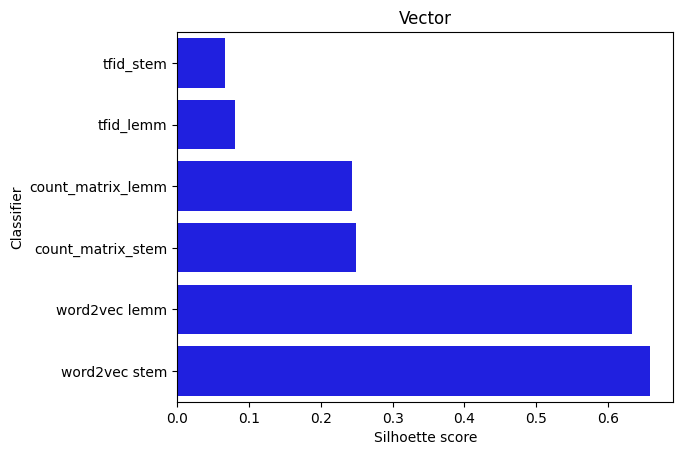

In [48]:

plt.xlabel('Silhoette score')
plt.title('Vector')

sns.barplot(x='Silhoette score', y='Classifier', data=log.sort_values(by='Silhoette score'), color="b")